# Machine Learning Demonstrations - 3

To run this notebooks, you need to install python dependencies:

With pip:

```pip install numpy==1.14.0
pip install matplotlib==2.0.2
pip install scikit_learn==0.19.1```

## Classification using k-Nearest Neighbors

The k-Nearest Neighbors (k-NN) algorithm is a simple but effective algorithm, used for supervised classification and regression problems.

For a given test point, k-Nearest-Neighbours finds the **k** datapoints in the training set that are *closest* to that point in the feature space.  
The prediciton is the average (for regression) or modal (for classification) value of the neighbors.

k-Nearest Neighbours is considered a non-parametric model, as it does not strictly *train* on the data. Instead, it retains the entire training dataset, to predict new test points.

n.b. Although k-NN is considered non-parametric, the number of neighbors considered (k) is an important _hyperparameter_ to the model.

Further discussion of k-NN can be found on the [Wikipedia article](https://en.wikipedia.org/wiki/K-nearest_neighbors_algorithm) or [Sci-Kit Learn documentation](http://scikit-learn.org/stable/modules/neighbors.html).

## Breast Cancer Data
The Wisconsin Breast Cancer dataset is a set of 569 samples of fine needle aspirate (FNA) of breast mass. Each sample contains features describing characteristics of the cell nuclei , along with a classification of the sample as either benign or malignant.

### Load data

In [1]:
/ Utility functions
\l ../utils/funcs.q
\l ../utils/graphics.q

In [2]:
data:.p.import[`sklearn.datasets;`:load_breast_cancer][]
features:data[`:data]`
target:data[`:target]`
targetnames:getunicode data`:target_names
featurenames:getunicode data`:feature_names
/ Inspect data
-1"\nShape of features is ",sv[" x "]string shape features;
-1"";show 5#features;-1"";
-1"Missing feature values: - ",string sum where null raze features;
-1"Missing target values:  - ",string sum where null raze target;
-1"\nDistribution of target values is:\n";
show update pcnt:round[;.01]100*num%sum num from select num:count i by target from([]target);


Shape of features is 569 x 30

17.99 10.38 122.8 1001  0.1184  0.2776  0.3001 0.1471  0.2419 0.07871 1.095  ..
20.57 17.77 132.9 1326  0.08474 0.07864 0.0869 0.07017 0.1812 0.05667 0.5435 ..
19.69 21.25 130   1203  0.1096  0.1599  0.1974 0.1279  0.2069 0.05999 0.7456 ..
11.42 20.38 77.58 386.1 0.1425  0.2839  0.2414 0.1052  0.2597 0.09744 0.4956 ..
20.29 14.34 135.1 1297  0.1003  0.1328  0.198  0.1043  0.1809 0.05883 0.7572 ..

Missing feature values: - 0
Missing target values:  - 0

Distribution of target values is:

target| num pcnt 
------| ---------
0     | 212 37.26
1     | 357 62.74


Classes are quite unbalanced
- 37% are malignant (0)
- 63% are benign (1)
A predictor that naively predicted _bengin_ (1) would therefore achieve nearly 63% accuracy on this dataset. However, such a model would not be of much use in classifying cells.

### Feature scaling 

k-Nearest Neighbours needs to calculate the *distance* between points in the feature space, in order to identify the k *nearest* points. The features must therefore be standardized, so that all are on the same scale. Otherwise, the feature with the most magnified scale will get the highest weighting in terms of prediction.

We can inspect the range of each of the 30 features for the dataset.

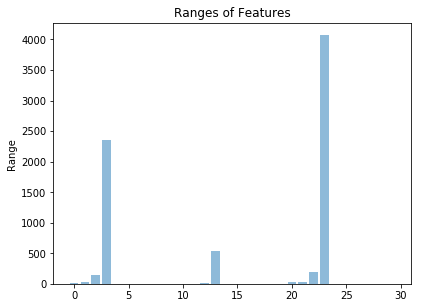

In [3]:
colranges:range features
ypos:til count features 0
/ Display using matplotlib
plt:.p.import`matplotlib.pyplot
plt[`:bar][ypos;colranges;`align pykw"center";`alpha pykw 0.5];
plt[`:ylabel]"Range";
plt[`:title]"Ranges of Features";
plt[`:show][];

The features have significantly different ranges, so standardization will be required.  
We scale each of the features independently into a range 0-1

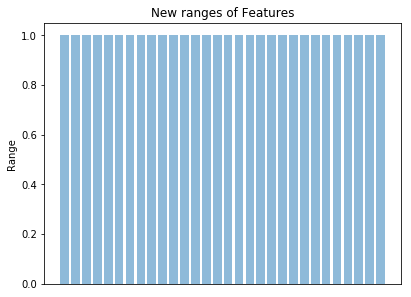

In [4]:
featuresscaled:minmaxscaler features; 
newcolranges:range featuresscaled
/ Display using matplotlib
plt[`:bar][ypos;newcolranges;`align pykw "center"; `alpha pykw 0.5];
plt[`:xticks]();
plt[`:ylabel]"Range";
plt[`:title]"New ranges of Features";
plt[`:show][];

A k-Nearest-Neighbours classifier predicts the class of test examples by finding (for **each** test point) the k datapoints in the training set that are "closest" to the test point in the feature space.

As such, the k-Nearest-Neighbour classifier does not strictly **train** on the data, it instead essentially retains all of it and uses the entire dataset to predict the classification of new test points. Implementations, including the one in sklearn may build tree structures based on the training set to optimize later querying of the nearest neighbors from a test set. 

The number of nearest neighbours (k) we choose to compare any new test-point to is an important hyperparameter in the k-Nearest-Neighbours classifiers.

We will split the data into training and test sets and evaluate the classifier's accuracy across a range of values for k.

### Split data
50/50 training/test split

In [5]:
\S 123 / random seed
show count each datadict:traintestsplit[features;target;.5]

xtrain| 284
ytrain| 284
xtest | 285
ytest | 285


### Fit and evaluate model

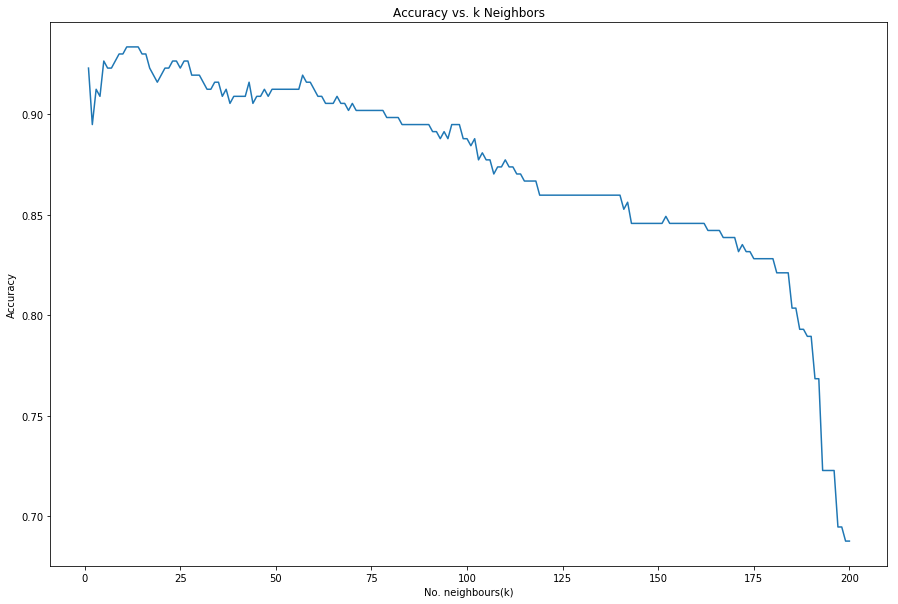

In [6]:
KNClassifier:.p.import[`sklearn.neighbors]`:KNeighborsClassifier
// Function to fit, predict and compute accuracy (for a given k)
checkaccuracy:{[k] 
 classifier:KNClassifier[`n_neighbors pykw k;`metric pykw "minkowski"]; 
 classifier[`:fit]. datadict`xtrain`ytrain; 
 pred:classifier[`:predict;datadict.xtest]`; 
 / use accuracy function from Func.q
 accuracy[datadict.ytest;pred]
 } 
/ Evaluate k = 1-200
maxk:200
accuracies:checkaccuracy each ypos:1+til maxk
/ Display using matplotlib
plot:.p.wrap each `fig`ax!plt[`:subplots][]`;
plot.fig[`:set_figheight]10;
plot.fig[`:set_figwidth]15;
plot.ax[`:plot][ypos;accuracies];
plt[`:xlabel]"No. neighbours(k)";
plt[`:ylabel]"Accuracy";
plt[`:title]"Accuracy vs. k Neighbors";
plt[`:show][];

For k<11, accuracy improves as k increases, indicating that the model overfits the data for very low values of k, this is, it memorizes the training data and gets almost perfect predictions for the training data but it does not generalize well to unseen data. Taking more neighbors into account to get the prediction will better generalize the data and will improve the accuracy on the test data.

For k>11, accuracy worsens as k increases. Beyond this point, the model suffers for underfitting the training data, this is, it oversimplifies the distribution of the data and it could miss some important details of the distribution. Adding more degrees-of-freedom will only make matters worse.

The optimal choice of k therefore appears to be 11.

This is an example of hyperparameter *tuning*, used to evaluate the best value of a hyperparameter. More complicated strategies (such as k-fold cross-validation) use different splits of training and validation data, increasing the overall data available for training.

The k-NN classifier (with k=11) obtains 93% accuracy on the test dataset. This shows significant predictive power over the baseline strategy of always predicting the most popular class (63% accuracy).